In [7]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import parametric_bootstrap
import numba as nb

In [8]:
@nb.njit
def compute_sample_sigma(ya_boots, n, d):
    """
    Given a dynamic embedding (T, n, n), compute the sample covariance matrix for each node
    """
    sigma_hats = np.zeros((n, d, d))
    for i in range(n):
        sigma_hats[i] = np.cov(ya_boots[:, i, :].T)

    return sigma_hats

@nb.njit
def get_power_fast(p_hat_list):
    """
    Given a list of p-values, compute the power at the 5% significance level
    """
    roc = np.zeros((100,))
    alphas = np.linspace(0, 1, 100)
    for i in range(100):
        alpha = alphas[i]
        num_below_alpha = np.sum(p_hat_list < alpha)
        roc[i] = num_below_alpha / len(p_hat_list)

    # Get the power at the 5% significance level
    power_significance = 0.05
    power_idx = np.argmin(np.abs(alphas - power_significance))
    power = roc[power_idx]

    return power

def plot_power(p_hat_list):
    # Plot the ROC curve
    roc = []
    alphas = []
    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Get the power at the 5% significance level
    power_significance = 0.05
    power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
    power = roc[power_idx]

    plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
    _ = plt.plot(alphas, roc)
    plt.show()

    return power

In [9]:
T = 100  # Number of true resamples to estimate sigma from
d = 2 # Dimension of SBM
d_bootstrap = d # Dimension of X (where we bootstrap from XXT)
n = 500 # number of nodes in SBM

# SBM cluster "distance" (0.5 = indistinguishable, 0.9 = well separated)
iid_prob = 0.5 # Easier to bootstrap
# iid_prob = 0.9 # Harder to bootstrap

B = 1  # Number of bootstrapped resamples
n_sim = 1000 # Number of simulations to estimate a p-value with

community_of_interest = 0  # Set of nodes to perform testing on

In [10]:
# Generate many SBMs and bootstrap from the first graph
A_true, tau = make_iid(
    n, T, iid_prob=iid_prob
)  # True resamples (many to estimate sigma)
A_boots = parametric_bootstrap(
    A_true[0], d_bootstrap, B=B, sparse=False, verbose=False
)

# Unfold true and bootstrap graphs
A_boots_with_true = np.concatenate((A_true, A_boots), axis=0)

# Embed observed and bootstrapped graphs
ya_boots_with_true = UASE(A_boots_with_true, d, flat=False, sparse_matrix=False)

del A_boots_with_true # Free up memory

####################################################################
n_test = n
# OPTIONAL: Select the community of interest to test on
# ------------------------------------------------------------------
# node_set = np.where(tau == community_of_interest)[0]
# ya_boots_with_true = ya_boots_with_true[:, node_set, :].copy()
# n_test = len(node_set)
####################################################################

ya_boots = ya_boots_with_true[T:].copy()  # Bootstrap embedding
ya_true = ya_boots_with_true[:T].copy()  # Embedding of observed T graphs
ya_obs = ya_true[0].copy()  # Embedding of observed graph
del ya_boots_with_true


# Estimate sigma from the true resamples for each node
sigma_true = compute_sample_sigma(ya_true, n_test, d)
assert np.sum(np.isnan(sigma_true)) == 0
del ya_true

# For each node, we expect that |Xobs_i - Xtrue_i| ~ N(0, 2 sigma_i)
# H0: |Xobs_i - Xboots_i| ~ N(0, 2 sigma_i)
# H1: |Xobs_i - Xboots_i| !~ N(0, 2 sigma_i)
# We get a p-value for each node (as we are not assuming constant variance in general)
# As we're working with a random graph where we DO have constant variance, I'll just treat these as
#  n p-values for the same node
p_vals = np.zeros((n_test,))
for i in range(n_test):
    all_tests = np.zeros((n_sim + 1,))
    t_obs = np.linalg.norm(ya_obs[i, :] - ya_boots[0, i, :])
    all_tests[0] = t_obs

    # (Yobs - Yboots) - if the bootstrap is perfect, Yboots_i has covariance sigma_true
    #  therefore the covariance in this case will be 2 sigma_true.
    # Therefore our null distribution is N(0, 2 sigma_true)
    normal_samples = np.random.multivariate_normal(
        np.zeros(d), 2 * (sigma_true[i]), size=n_sim
    )
    all_tests[1:] = np.linalg.norm(normal_samples, axis=1)

    # Compute p-value (how extreme is our observed vs the null distribution)
    p_vals[i] = 1 / (n_sim + 1) * np.sum(all_tests >= t_obs)

power = get_power_fast(p_vals)
print("Power:", power)

Power: 0.066


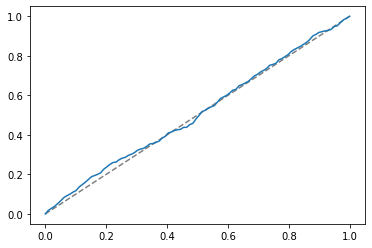

0.066

In [11]:
plot_power(p_vals)

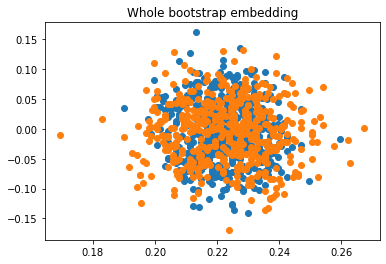

In [12]:
plt.figure()
plt.title("Whole bootstrap embedding")
plt.scatter(ya_obs[:, 0], ya_obs[:, 1], label="True")
plt.scatter(ya_boots[0, :, 0], ya_boots[0, :, 1], label="Bootstrap")

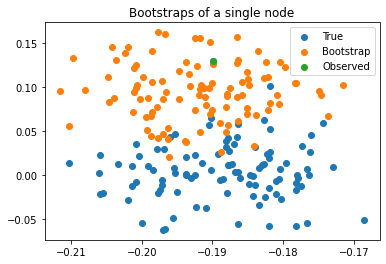

In [13]:
###############################################
## The bootstrap node distribution does not line up with the true

## The variance of the bootstrap node distributions does look like the true
###############################################
plt.figure()
plt.title("Bootstraps of a single node")

B_plot = 100
As_boots_plot = parametric_bootstrap(
    A_true[0], d, B=B_plot, sparse=False, verbose=False
)
As_boots_and_obs_plot = np.concatenate((A_true, As_boots_plot), axis=0)
ya_boots_and_obs_plot = UASE(As_boots_and_obs_plot, d, flat=False, sparse_matrix=False)
ya_true_plot = ya_boots_and_obs_plot[:T].copy()
ya_boots_plot = ya_boots_and_obs_plot[T : B_plot + T].copy()
ya_obs_plot = ya_boots_and_obs_plot[0].copy()

node_to_plot = 0
plt.scatter(
    ya_true_plot[:, node_to_plot, 0],
    ya_true_plot[:, node_to_plot, 1],
    label="True",
)
plt.scatter(
    ya_boots_plot[:, node_to_plot, 0],
    ya_boots_plot[:, node_to_plot, 1],
    label="Bootstrap",
)
plt.scatter(
    ya_obs_plot[node_to_plot, 0], ya_obs_plot[node_to_plot, 1], label="Observed"
)
plt.legend()